# first we have to divide the data for our use case per day for each revenue center

In [1]:
import pandas as pd

file_path = "../data/raw/Hotel_Revenue_Data.xlsx"

# Use read_excel instead of read_csv
df = pd.read_excel(file_path, parse_dates=["Date"])

# Quick sanity-check
print(df.shape)
df.head()


(120562, 4)


,Date,MealPeriod,CheckTotal,RevenueCenterName
0,2023-04-18,Dinner,125.0,RevenueCenter_1
1,2023-04-18,Dinner,37.5,RevenueCenter_1
2,2023-04-18,Dinner,0.0,RevenueCenter_1
3,2023-04-18,Dinner,0.0,RevenueCenter_1
4,2023-04-18,Dinner,70.0,RevenueCenter_2


In [2]:
import pandas as pd
import itertools

# Step 1: Get all unique values
all_dates = df["Date"].unique()
all_meals = df["MealPeriod"].unique()
all_centers = df["RevenueCenterName"].unique()

# Step 2: Create full cartesian product of all combinations
all_combinations = pd.DataFrame(
    list(itertools.product(all_dates, all_meals, all_centers)),
    columns=["Date", "MealPeriod", "RevenueCenterName"]
)

# Step 3: Group actual data
actual_totals = (
    df.groupby(["Date", "MealPeriod", "RevenueCenterName"])["CheckTotal"]
    .sum()
    .reset_index()
    .rename(columns={"CheckTotal": "TotalCheckAmount"})
)

# Step 4: Merge with full combinations and fill missing with 0
final_df = (
    all_combinations
    .merge(actual_totals, on=["Date", "MealPeriod", "RevenueCenterName"], how="left")
    .fillna({"TotalCheckAmount": 0})
    .sort_values(by=["Date", "MealPeriod", "RevenueCenterName"])
)

# Step 5: Save to CSV
final_df.to_csv("complete_daily_revenue_totals.csv", index=False)

final_df.head()

,Date,MealPeriod,RevenueCenterName,TotalCheckAmount
963,2023-01-01,BreakFast,RevenueCenter_1,1499.4
964,2023-01-01,BreakFast,RevenueCenter_2,35.0
965,2023-01-01,BreakFast,RevenueCenter_3,0.0
966,2023-01-01,BreakFast,RevenueCenter_4,0.0
967,2023-01-01,BreakFast,RevenueCenter_5,21807.0


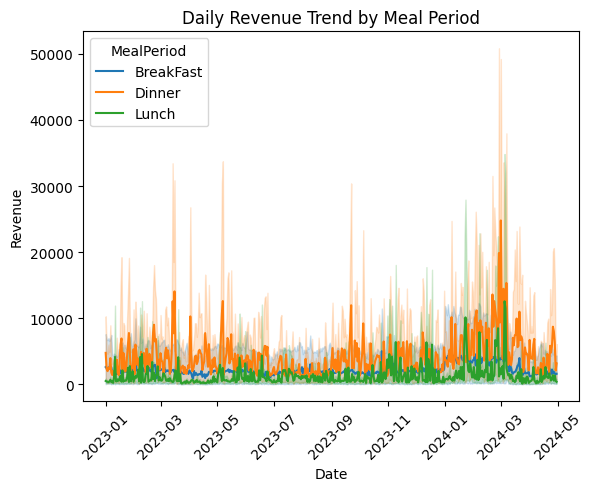

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a line plot with 'Date' on the x-axis and 'TotalCheckAmount' on the y-axis
# Different lines are colored by 'MealPeriod'
sns.lineplot(data=final_df, x="Date", y="TotalCheckAmount", hue="MealPeriod")

# Set the title of the plot
plt.title("Daily Revenue Trend by Meal Period")

# Label the y-axis as 'Revenue'
plt.ylabel("Revenue")

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


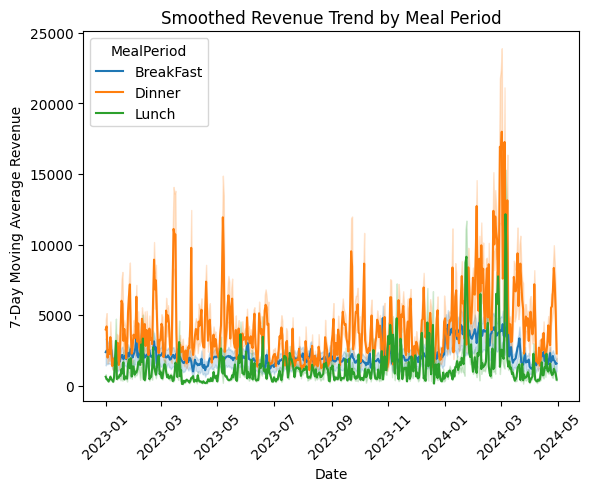

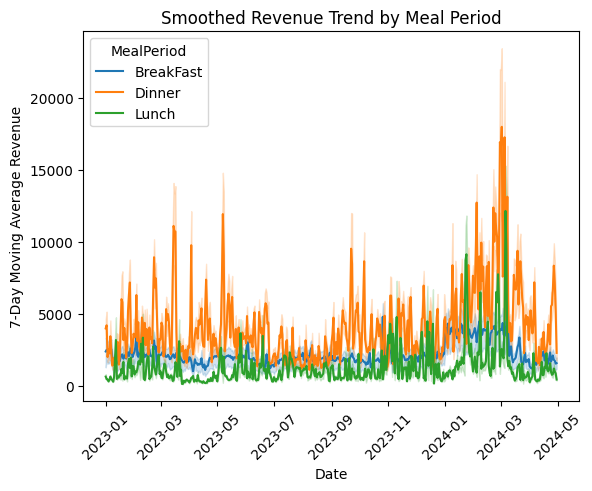

In [4]:
# Smooth revenue with 7-day moving average
smoothed = final_df.copy()
smoothed["TotalCheckAmount"] = smoothed.groupby("MealPeriod")["TotalCheckAmount"].transform(lambda x: x.rolling(7, min_periods=1).mean())

sns.lineplot(data=smoothed, x="Date", y="TotalCheckAmount", hue="MealPeriod")
plt.title("Smoothed Revenue Trend by Meal Period")
plt.ylabel("7-Day Moving Average Revenue")
plt.xticks(rotation=45)
plt.show()
# Smooth revenue with 7-day moving average
smoothed = final_df.copy()
smoothed["TotalCheckAmount"] = smoothed.groupby("MealPeriod")["TotalCheckAmount"].transform(lambda x: x.rolling(7, min_periods=1).mean())

sns.lineplot(data=smoothed, x="Date", y="TotalCheckAmount", hue="MealPeriod")
plt.title("Smoothed Revenue Trend by Meal Period")
plt.ylabel("7-Day Moving Average Revenue")
plt.xticks(rotation=45)
plt.show()


Text(0.5, 0.98, 'Revenue Trends by Revenue Center and Meal Period')

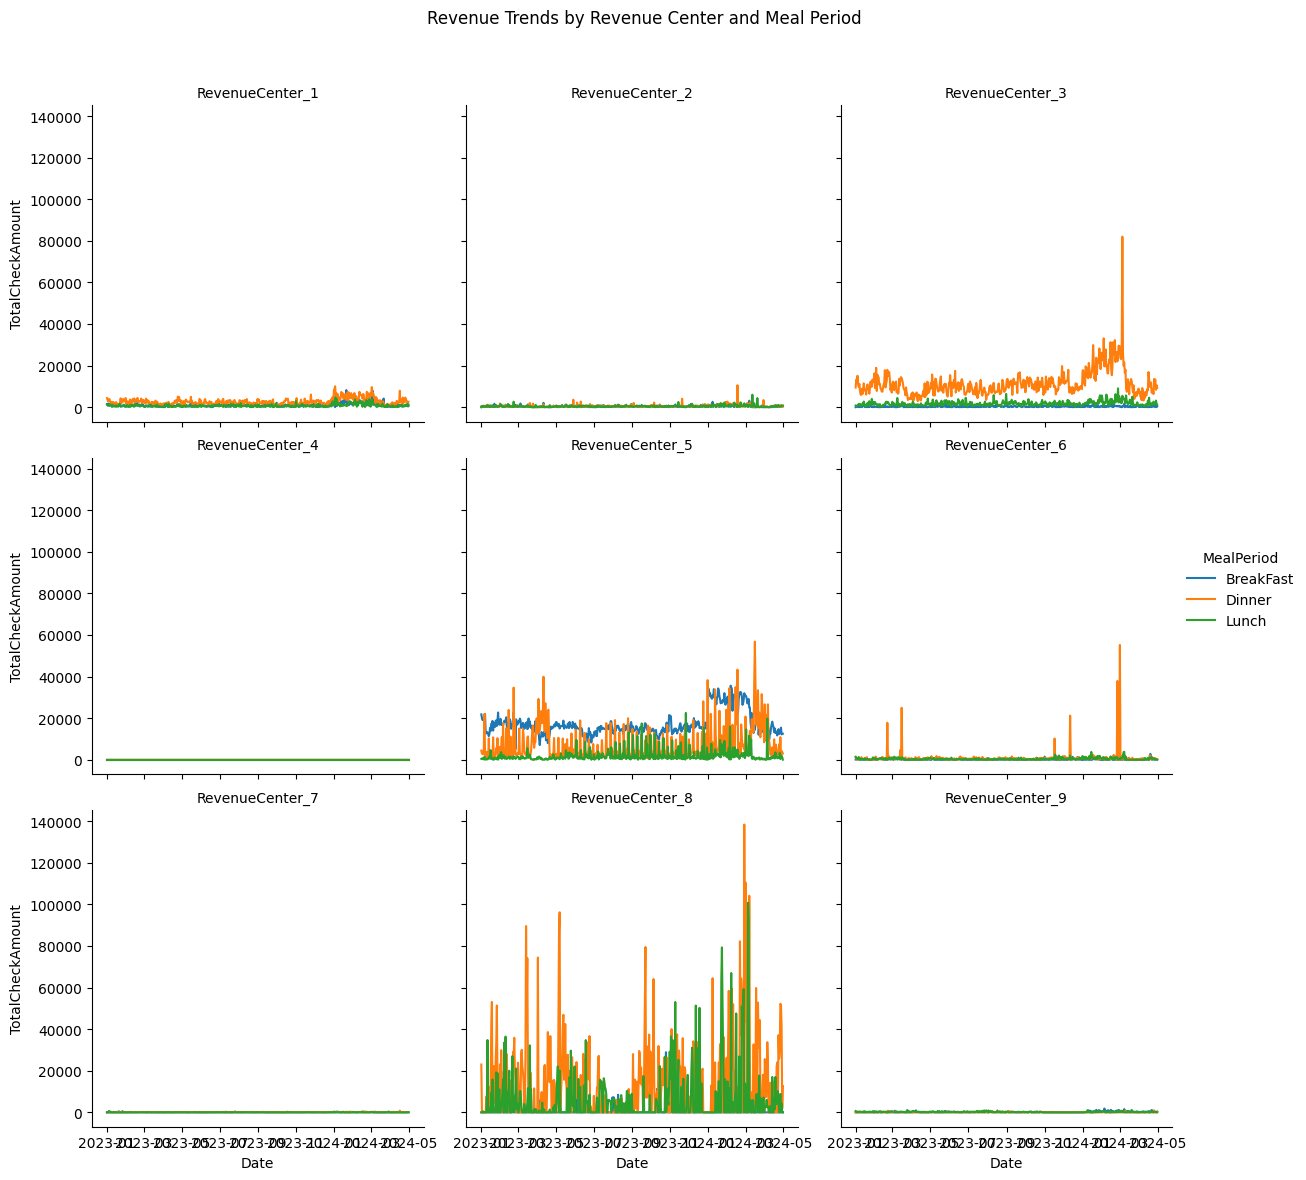

In [5]:
g = sns.FacetGrid(final_df, col="RevenueCenterName", hue="MealPeriod", col_wrap=3, height=4)
g.map(sns.lineplot, "Date", "TotalCheckAmount").add_legend()
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Revenue Trends by Revenue Center and Meal Period")


In [6]:
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Sort and apply 7-day moving average per MealPeriod + RevenueCenterName
smoothed_df = (
    final_df.sort_values("Date")
    .groupby(["MealPeriod", "RevenueCenterName"], as_index=False)
    .apply(lambda x: x.assign(SmoothedRevenue=x["TotalCheckAmount"].rolling(7, min_periods=1).mean()))
    .reset_index(drop=True)
)


/tmp/ipykernel_38785/1164184104.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(SmoothedRevenue=x["TotalCheckAmount"].rolling(7, min_periods=1).mean()))


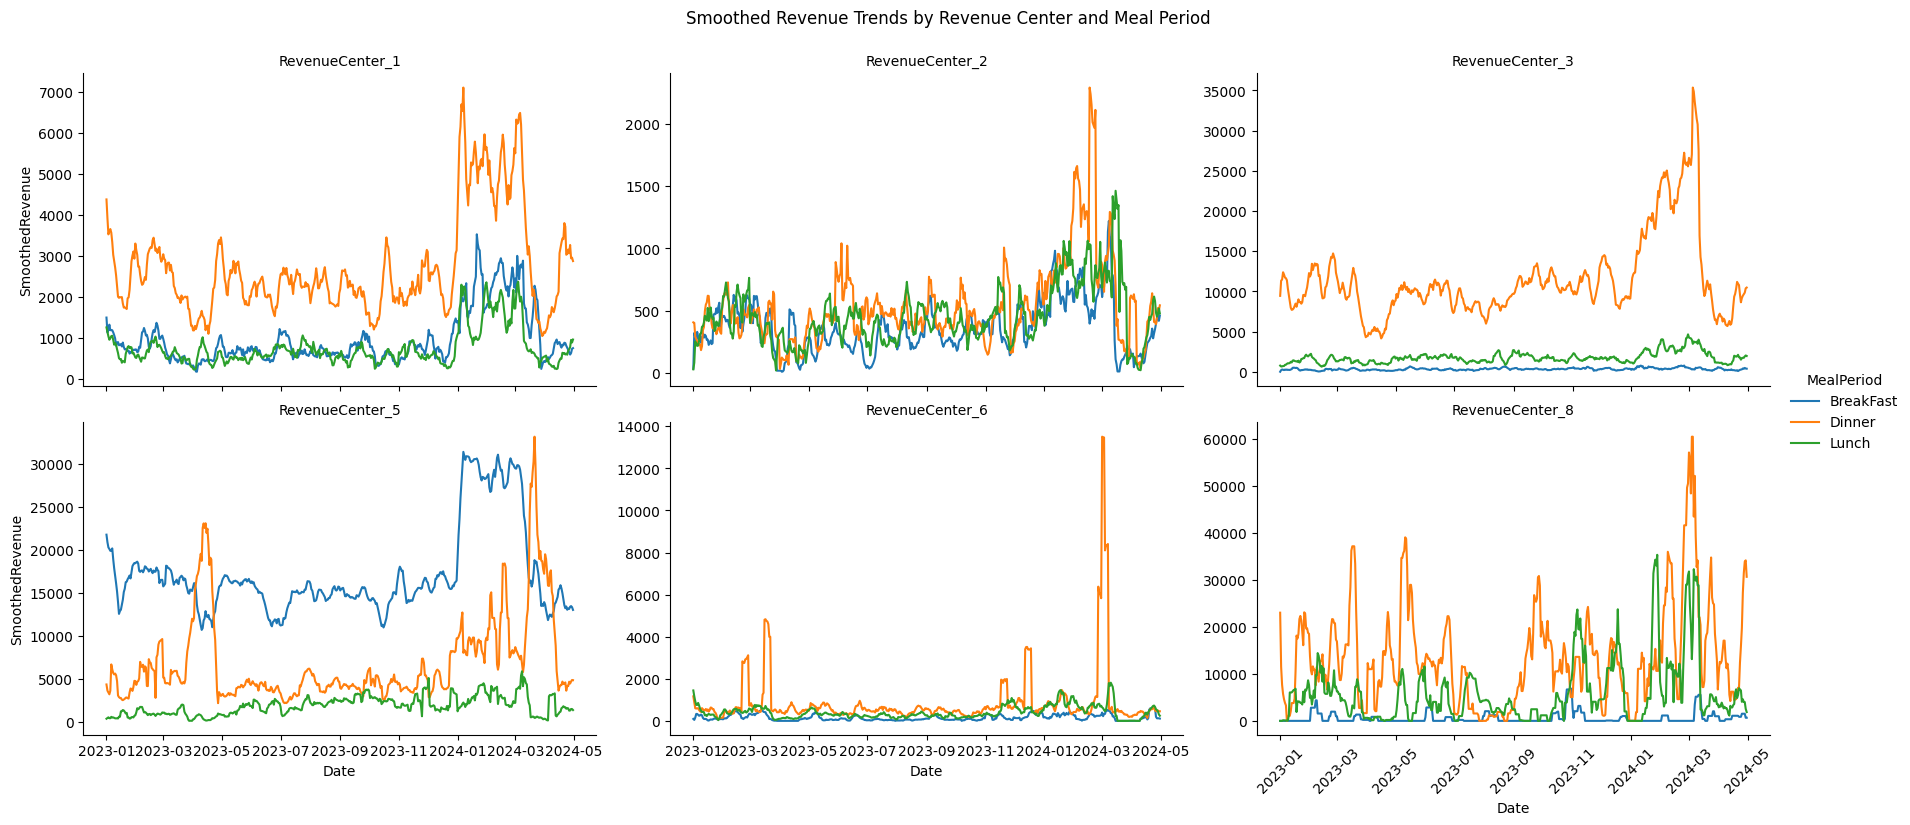

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot only active revenue centers (optional filter)
active_centers = smoothed_df.groupby("RevenueCenterName")["TotalCheckAmount"].sum().sort_values(ascending=False).head(6).index
filtered_df = smoothed_df[smoothed_df["RevenueCenterName"].isin(active_centers)]

g = sns.FacetGrid(
    filtered_df,
    col="RevenueCenterName",
    hue="MealPeriod",
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

g.map(sns.lineplot, "Date", "SmoothedRevenue").add_legend()
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Revenue Trends by Revenue Center and Meal Period")
plt.xticks(rotation=45)
plt.show()


In [8]:
##### feature engineering
import pandas as pd
import numpy as np

# --- Step 1: Load Data ---
# Load the complete time series you created.
df = pd.read_csv('complete_daily_revenue_totals.csv')

# Load your ORIGINAL rich dataset to get the daily features back (holidays, events, etc.)
# This is a CRITICAL step.
df_original = pd.read_csv('dubai_totals_sample.csv') 

# --- Step 2: Prepare and Merge Daily Features ---

# Ensure Date columns are in datetime format
df['Date'] = pd.to_datetime(df['Date'])
df_original['Date'] = pd.to_datetime(df_original['Date'])

# From the original data, get the unique features for each day.
# We can drop columns that are already in our main 'df' or are not needed.
daily_event_features = df_original.groupby('Date').first().reset_index()
features_to_merge = [
    'Date', 'IsRamadan', 'IsEid', 'IsMarathon', 'IsGITEX', 
    'IsFilmFestival', 'IsAirshow', 'IsArtDubai', 'IsFoodFestival', 
    'IsPreEvent', 'IsPostEvent', 'TourismIntensity'
]
# Select only the features we need to merge
daily_event_features = daily_event_features[features_to_merge]

# Merge these daily event features back into your main dataframe
df_featured = pd.merge(df, daily_event_features, on='Date', how='left')


# --- Step 3: Engineer Temporal Features ---

# Basic time features
df_featured['DayOfWeek'] = df_featured['Date'].dt.dayofweek # Monday=0, Sunday=6
df_featured['DayOfMonth'] = df_featured['Date'].dt.day
df_featured['WeekOfYear'] = df_featured['Date'].dt.isocalendar().week.astype(int)
df_featured['Month'] = df_featured['Date'].dt.month
df_featured['Quarter'] = df_featured['Date'].dt.quarter
df_featured['IsWeekend'] = (df_featured['DayOfWeek'] >= 5).astype(int) # 5=Saturday, 6=Sunday

# Advanced: Cyclical features for time (highly recommended for tree-based models)
df_featured['DayOfWeek_sin'] = np.sin(2 * np.pi * df_featured['DayOfWeek']/7)
df_featured['DayOfWeek_cos'] = np.cos(2 * np.pi * df_featured['DayOfWeek']/7)
df_featured['Month_sin'] = np.sin(2 * np.pi * df_featured['Month']/12)
df_featured['Month_cos'] = np.cos(2 * np.pi * df_featured['Month']/12)


# --- Step 4: Engineer Lag and Rolling Window Features (Most Powerful Features) ---

# IMPORTANT: Sort values to ensure lags and rolling windows are calculated correctly
df_featured = df_featured.sort_values(by=['RevenueCenterName', 'MealPeriod', 'Date'])

# Group by each individual time series
grouped = df_featured.groupby(['RevenueCenterName', 'MealPeriod'])

# Lag features: revenue from previous periods
df_featured['Lag_1_Day'] = grouped['TotalCheckAmount'].shift(1)
df_featured['Lag_7_Days'] = grouped['TotalCheckAmount'].shift(7) # Crucial for weekly seasonality
df_featured['Lag_14_Days'] = grouped['TotalCheckAmount'].shift(14)

# Rolling window features: captures recent trends
# We use .reset_index to drop the multi-level index created by groupby().transform()
df_featured['Rolling_Mean_7_Days'] = grouped['TotalCheckAmount'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
df_featured['Rolling_Std_7_Days'] = grouped['TotalCheckAmount'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).std())
df_featured['Rolling_Mean_14_Days'] = grouped['TotalCheckAmount'].transform(lambda x: x.shift(1).rolling(14, min_periods=1).mean())

# Fill NaNs created by lags/rolling windows. We can use 0 or backfill.
df_featured = df_featured.fillna(0)


# --- Step 5: Encode Categorical Features ---

# Use one-hot encoding to turn text categories into model-readable features
# This is how the single model learns the patterns for each center/meal
categorical_cols = ['MealPeriod', 'RevenueCenterName', 'TourismIntensity']
df_final_model_ready = pd.get_dummies(df_featured, columns=categorical_cols, drop_first=True)

# Drop original date and other unnecessary columns before training
df_final_model_ready = df_final_model_ready.drop(columns=['Date'])

print("--- Model-Ready DataFrame ---")
print(df_final_model_ready.head())

print("\n--- Final Columns for the Model ---")
print(df_final_model_ready.columns.tolist())

--- Model-Ready DataFrame ---
     TotalCheckAmount  IsRamadan  IsEid  IsMarathon  IsGITEX  IsFilmFestival  \
0              1499.4          0      0           0        0               0   
27              771.0          0      0           0        0               0   
54             1302.4          0      0           0        0               0   
81             1737.0          0      0           0        0               0   
108             653.0          0      0           0        0               0   

     IsAirshow  IsArtDubai  IsFoodFestival  IsPreEvent  ...  \
0            0           0               0           0  ...   
27           0           0               0           0  ...   
54           0           0               0           0  ...   
81           0           0               0           0  ...   
108          0           0               0           0  ...   

     RevenueCenterName_RevenueCenter_3  RevenueCenterName_RevenueCenter_4  \
0                                

In [9]:
X = df_final_model_ready.drop(columns=['TotalCheckAmount'])
y = df_final_model_ready['TotalCheckAmount']

In [10]:
X

,IsRamadan,IsEid,IsMarathon,IsGITEX,IsFilmFestival,IsAirshow,IsArtDubai,IsFoodFestival,IsPreEvent,IsPostEvent,...,RevenueCenterName_RevenueCenter_3,RevenueCenterName_RevenueCenter_4,RevenueCenterName_RevenueCenter_5,RevenueCenterName_RevenueCenter_6,RevenueCenterName_RevenueCenter_7,RevenueCenterName_RevenueCenter_8,RevenueCenterName_RevenueCenter_9,TourismIntensity_Low,TourismIntensity_Medium,TourismIntensity_Normal
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
27,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,True
54,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,False,False,False,True
81,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
108,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13013,1,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,True,False,False,True
13040,1,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,True,False,False,True
13067,1,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,True,False,False,True
13094,1,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,False,True,False,False,True


In [11]:
# print all the columns of X
print(X.columns.tolist())

['IsRamadan', 'IsEid', 'IsMarathon', 'IsGITEX', 'IsFilmFestival', 'IsAirshow', 'IsArtDubai', 'IsFoodFestival', 'IsPreEvent', 'IsPostEvent', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Quarter', 'IsWeekend', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Lag_1_Day', 'Lag_7_Days', 'Lag_14_Days', 'Rolling_Mean_7_Days', 'Rolling_Std_7_Days', 'Rolling_Mean_14_Days', 'MealPeriod_Dinner', 'MealPeriod_Lunch', 'RevenueCenterName_RevenueCenter_2', 'RevenueCenterName_RevenueCenter_3', 'RevenueCenterName_RevenueCenter_4', 'RevenueCenterName_RevenueCenter_5', 'RevenueCenterName_RevenueCenter_6', 'RevenueCenterName_RevenueCenter_7', 'RevenueCenterName_RevenueCenter_8', 'RevenueCenterName_RevenueCenter_9', 'TourismIntensity_Low', 'TourismIntensity_Medium', 'TourismIntensity_Normal']


In [12]:
# For example, use 2023 data for training and 2024 for testing
date_column = df_featured['Date'] # Keep the date column handy for splitting

train_indices = date_column[date_column < '2024-01-01'].index
test_indices = date_column[date_column >= '2024-01-01'].index

X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (9855, 39)
Test set shape: (3267, 39)


In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_featured and df_final_model_ready are already created from the previous steps ---
# If you are starting fresh, run the feature engineering code first to create these.

# Let's recreate them quickly for a self-contained script.
# This is a simplified version of the full feature engineering script.
# In your actual notebook, you would just continue from where you left off.
df = pd.read_csv('complete_daily_revenue_totals.csv')
df_original = pd.read_csv('dubai_totals_sample.csv')  # Load the original rich dataset
df['Date'] = pd.to_datetime(df['Date'])
df_original['Date'] = pd.to_datetime(df_original['Date'])
daily_event_features = df_original.groupby('Date').first().reset_index()
features_to_merge = [
    'Date', 'IsRamadan', 'IsEid', 'IsMarathon', 'IsGITEX', 
    'IsFilmFestival', 'IsAirshow', 'IsArtDubai', 'IsFoodFestival'
]
df_featured = pd.merge(df, daily_event_features[features_to_merge], on='Date', how='left')
df_featured['DayOfWeek'] = df_featured['Date'].dt.dayofweek
df_featured['Month'] = df_featured['Date'].dt.month
df_featured = df_featured.sort_values(by=['RevenueCenterName', 'MealPeriod', 'Date'])
grouped = df_featured.groupby(['RevenueCenterName', 'MealPeriod'])
df_featured['Lag_7_Days'] = grouped['TotalCheckAmount'].shift(7)
df_featured['Rolling_Mean_7_Days'] = grouped['TotalCheckAmount'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
df_featured = df_featured.fillna(0)
categorical_cols = ['MealPeriod', 'RevenueCenterName']
df_featured['DayOfWeek_Ramadan'] = df_featured['DayOfWeek'] * df_featured['IsRamadan']
df_featured['Month_Ramadan'] = df_featured['Month'] * df_featured['IsRamadan']
df_final_model_ready = pd.get_dummies(df_featured, columns=categorical_cols, drop_first=True)
# --- End of quick recreation ---


# --- 1. Define Features (X) and Target (y) ---
# The target is the revenue we want to predict
y = df_final_model_ready['TotalCheckAmount']

# The features are everything else (except the date, which we use for splitting)
X = df_final_model_ready.drop(columns=['TotalCheckAmount', 'Date'])


# --- 2. Chronological Data Split (CRITICAL for Time Series) ---
# We will use the date from the 'df_featured' dataframe to split.
# Let's use the last 3 months of data for our test set, as per the project objective.
split_date = df_featured['Date'].max() - pd.DateOffset(months=3)

train_indices = df_featured[df_featured['Date'] < split_date].index
test_indices = df_featured[df_featured['Date'] >= split_date].index

X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Also keep the corresponding part of df_featured to analyze results later
test_info_df = df_featured.loc[test_indices]


print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training period: {df_featured.loc[train_indices, 'Date'].min().date()} to {df_featured.loc[train_indices, 'Date'].max().date()}")
print(f"Test period:     {df_featured.loc[test_indices, 'Date'].min().date()} to {df_featured.loc[test_indices, 'Date'].max().date()}")

Training data shape: (10638, 24)
Test data shape: (2484, 24)
Training period: 2023-01-01 to 2024-01-29
Test period:     2024-01-30 to 2024-04-30


In [14]:
import time

# --- 3. Define and Train the LightGBM Model ---

# Define model parameters. These are good starting points.
lgb_params = {
    'objective': 'regression_l1',  # L1 loss is often more robust to outliers than L2 (mse)
    'metric': 'mae',               # Metric for the model to optimize
    'n_estimators': 2000,          # Number of trees to build
    'learning_rate': 0.01,
    'feature_fraction': 0.8,       # Fraction of features to use for each tree
    'bagging_fraction': 0.8,       # Fraction of data to use for each tree
    'bagging_freq': 1,
    'lambda_l1': 0.1,              # L1 regularization
    'lambda_l2': 0.1,              # L2 regularization
    'num_leaves': 31,              # Number of leaves in one tree
    'verbose': -1,                 # Suppress verbose output
    'n_jobs': -1,                  # Use all available cores
    'seed': 42,
    'boosting_type': 'gbdt',
}

# Start the timer for training
start_train_time = time.time()

# Initialize and train the model
model = lgb.LGBMRegressor(**lgb_params)

# Use an evaluation set to enable early stopping
# The model will stop training if the validation score doesn't improve for 100 rounds
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(100, verbose=True)])

# Stop the timer
end_train_time = time.time()
training_time = end_train_time - start_train_time

print(f"\n--- Training Efficiency ---")
print(f"Model training took: {training_time:.2f} seconds")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[978]	valid_0's l1: 1991.83

--- Training Efficiency ---
Model training took: 3.21 seconds


In [15]:
# --- 4. Make Predictions and Evaluate ---

# Start the timer for forecasting
start_pred_time = time.time()

# Generate predictions on the test set
predictions = model.predict(X_test)

# Stop the timer
end_pred_time = time.time()
prediction_time = end_pred_time - start_pred_time

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test[y_test > 0], predictions[y_test > 0]) # Avoid division by zero

print(f"\n--- Forecasting Speed ---")
print(f"Generating {len(X_test)} predictions took: {prediction_time:.4f} seconds")

print(f"\n--- Forecasting Performance ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2%}")


--- Forecasting Speed ---
Generating 2484 predictions took: 0.0539 seconds

--- Forecasting Performance ---
RMSE: 7422.31
MAE:  1991.83
MAPE: 86.11%


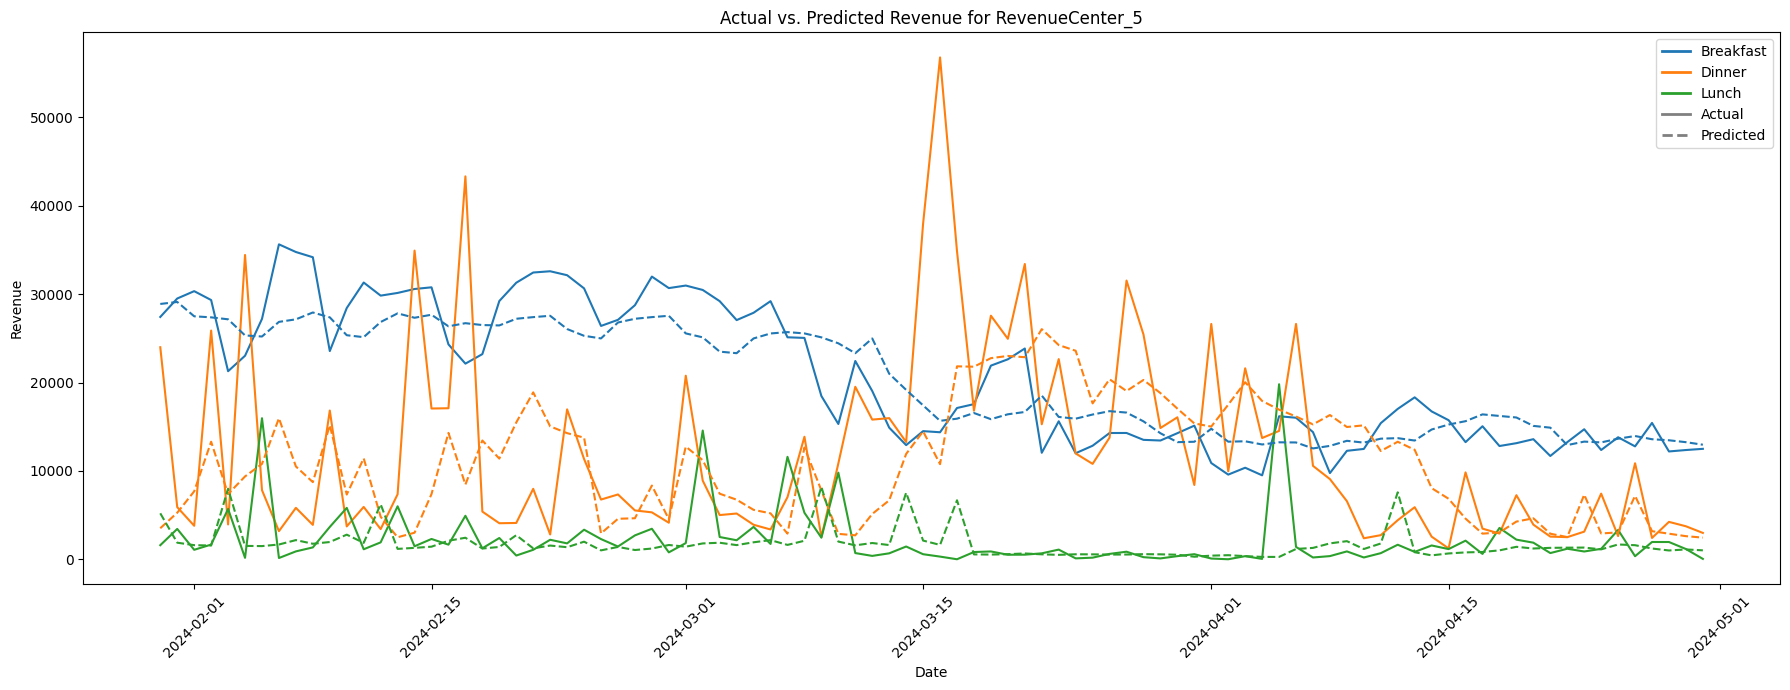

<Figure size 1000x800 with 0 Axes>

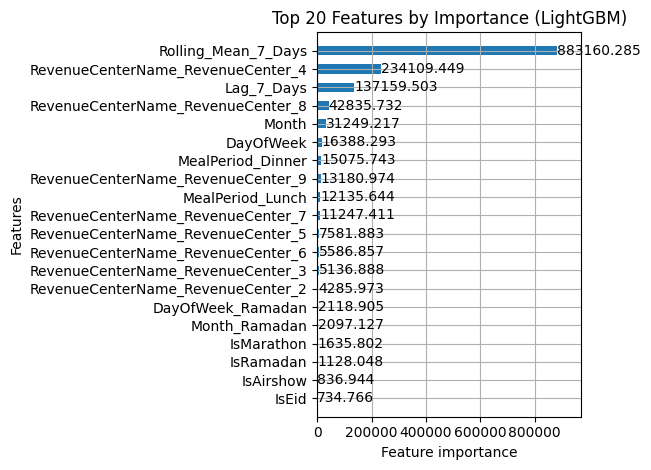

In [16]:
# --- 5. Visualize Results and Feature Importance (CORRECTED) ---

# Add predictions back to our test info dataframe for easy plotting
results_df = test_info_df.copy()
results_df['PredictedRevenue'] = predictions

# A. Plotting Predictions vs Actuals for a specific Revenue Center
plt.figure(figsize=(18, 7))

# Let's pick a high-revenue center to visualize
center_to_plot = 'RevenueCenter_5' 
plot_data = results_df[results_df['RevenueCenterName'] == center_to_plot]

# --- FIX IS HERE: REMOVED label='...' from both lines ---
sns.lineplot(data=plot_data, x='Date', y='TotalCheckAmount', hue='MealPeriod', errorbar=None)
sns.lineplot(data=plot_data, x='Date', y='PredictedRevenue', hue='MealPeriod', linestyle='--', errorbar=None)

# Manually create legend entries, which is a great way to have full control
from matplotlib.lines import Line2D
legend_elements = [
    # Lines for Meal Periods (colors will match seaborn's default palette)
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, label='Breakfast'),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, label='Dinner'),
    Line2D([0], [0], color=sns.color_palette()[2], lw=2, label='Lunch'),
    # Lines for line style (Actual vs. Predicted)
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Actual'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Predicted')
]

plt.title(f'Actual vs. Predicted Revenue for {center_to_plot}')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.legend(handles=legend_elements)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# B. Feature Importance Plot (This part was already correct)
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='gain', height=0.5)
plt.title('Top 20 Features by Importance (LightGBM)')
plt.tight_layout()
plt.show()

In [41]:
# combo of cnn + lstm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# --- 1. Load and Prepare the Final DataFrame ---
# We use the 'df_final_model_ready' which was created in the LGBM steps
# Make sure 'df_featured' (with the Date column) and 'df_final_model_ready' (without the Date) are loaded.
# If they are not in memory, you need to recreate them first.

# Use a copy to avoid changing the original dataframe
data_for_nn = df_final_model_ready.copy()
target_col = 'TotalCheckAmount'

# --- FIX IS HERE: Drop the 'Date' column if it exists BEFORE scaling ---
if 'Date' in data_for_nn.columns:
    data_for_nn = data_for_nn.drop(columns=['Date'])


# --- 2. Data Scaling ---
# Now the scaler will only see numerical columns, and it will work perfectly.
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_for_nn)

# We also need a separate scaler for JUST the target column to inverse transform later
target_scaler = MinMaxScaler()
target_scaler.fit(data_for_nn[[target_col]])

# --- 3. Chronological Split of SCALED data ---
# We still use df_featured for the split because it has the original Date column
split_date = df_featured['Date'].max() - pd.DateOffset(months=3)
train_indices = df_featured[df_featured['Date'] < split_date].index
test_indices = df_featured[df_featured['Date'] >= split_date].index

train_data = data_scaled[train_indices]
test_data = data_scaled[test_indices]


# --- 4. Create Sequential Windows ---
def create_dataset(dataset, target_index, look_back=14):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :] 
        dataX.append(a)
        dataY.append(dataset[i + look_back, target_index])
    return np.array(dataX), np.array(dataY)

look_back = 14
target_idx = data_for_nn.columns.get_loc(target_col)

X_train, y_train = create_dataset(train_data, target_idx, look_back)
X_test, y_test = create_dataset(test_data, target_idx, look_back)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (10624, 14, 25)
Shape of y_train: (10624,)
Shape of X_test: (2470, 14, 25)
Shape of y_test: (2470,)


/home/kuggix/miniconda3/envs/web/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 12, 32)         │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 25)             │         4,425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,883 (26.89 KB)

 Trainable params: 6,883 (26.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1907 - val_loss: 0.0114
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0012 - val_loss: 0.0073
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013 - val_loss: 0.0075
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 9/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 10/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 11/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 12/100
332/332 ━━━━━━━━━━━━━━━━━━━━

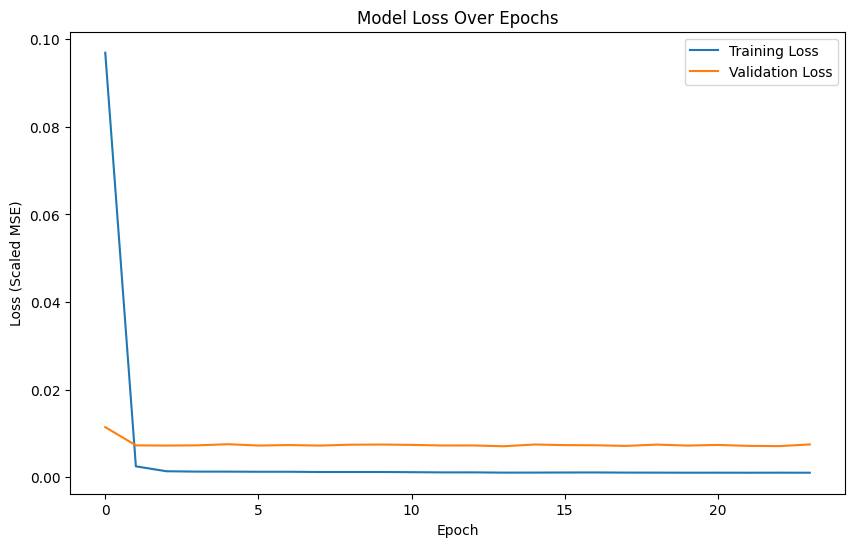

In [46]:
# # --- 5. Build the CNN-LSTM Model ---
# n_timesteps = X_train.shape[1]
# n_features = X_train.shape[2]

# model_cnn_lstm = Sequential([
#     # CNN layer to extract features from the sequence
#     Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
#     MaxPooling1D(pool_size=2),

#     # LSTM layer to understand the sequence of extracted features
#     # Using GRU is often a good, faster alternative to LSTM
#     GRU(units=50, activation='relu'),

#     # Dense layers to produce the final output
#     Dense(units=25, activation='relu'),
#     Dense(units=1) # Final output neuron
# ])

# # Compile the model
# # The 'adam' optimizer is a great default choice.
# model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

# model_cnn_lstm.summary()


# # --- 6. Train the Model ---
# # Training deep learning models takes longer, so we use fewer epochs for this test run.
# # 'batch_size' controls how many samples are processed before the model's weights are updated.
# history = model_cnn_lstm.fit(
#     X_train, y_train,
#     epochs=30,  # Start with 30, can increase if needed
#     batch_size=32,
#     validation_data=(X_test, y_test),
#     verbose=1
# )





from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# --- Build a more Robust CNN-LSTM Model ---
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# 1. Simplify the model and 2. Add Dropout and L2 Regularization
model_robust = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3), # Dropout layer after conv

    GRU(units=25, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)), # Fewer units and L2 reg
    Dropout(0.2), # Dropout layer after GRU

    Dense(units=1) # Simplified dense output
])

model_robust.compile(optimizer='adam', loss='mean_squared_error')
model_robust.summary()

# 3. Use an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=10,        # Stop after 10 epochs with no improvement
    restore_best_weights=True # Restore the weights from the best epoch
)

# Train the new robust model
history_robust = model_robust.fit(
    X_train, y_train,
    epochs=100, # We can set a high number, early stopping will handle it
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping], # Add the callback here
    verbose=1
)



# --- 7. Evaluate the Model ---
# Make predictions on the test set
predictions_scaled = model_robust.predict(X_test)

# Inverse scale the predictions to get actual revenue values
predictions = target_scaler.inverse_transform(predictions_scaled)

# Also inverse scale the true y_test values for comparison
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
nn_rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
nn_mae = mean_absolute_error(y_test_actual, predictions)

print("\n--- CNN-LSTM Model Performance ---")
print(f"RMSE: {nn_rmse:.2f}")
print(f"MAE:  {nn_mae:.2f}")

# Compare with your LightGBM benchmark
print("\n--- LightGBM Benchmark ---")
print(f"MAE:  1981.14") # Your previous result

# Plot training & validation loss to check for overfitting
plt.figure(figsize=(10, 6))
plt.plot(history_robust.history['loss'], label='Training Loss')
plt.plot(history_robust.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (Scaled MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

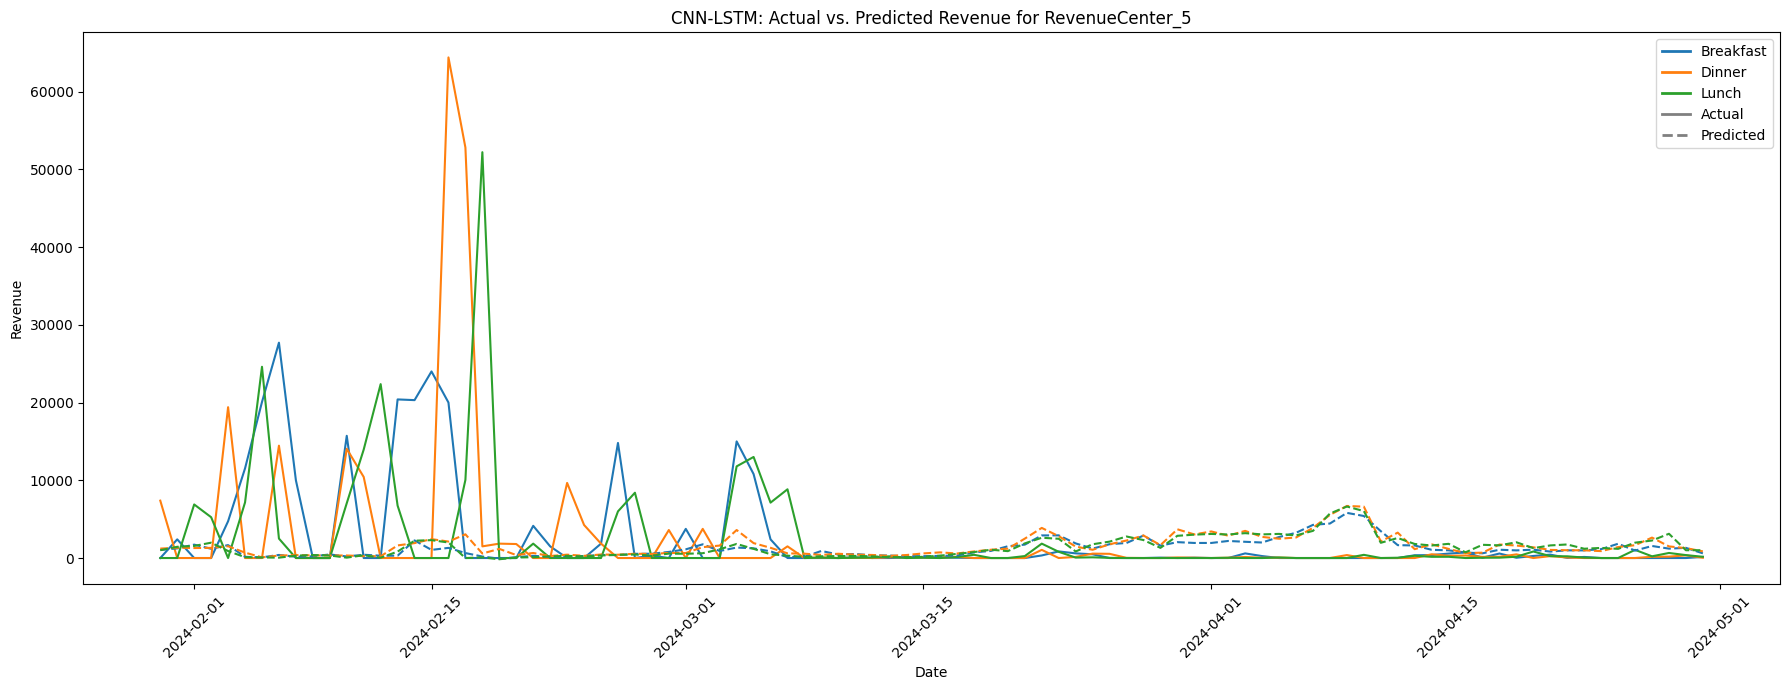

In [45]:
test_dates = df_featured.loc[test_indices, 'Date'][look_back:]

# Create a dataframe for plotting
results_nn_df = pd.DataFrame({
    'Date': test_dates,
    'ActualRevenue': y_test_actual.flatten(),
    'PredictedRevenue': predictions.flatten()
})

# Let's merge it with the original info to get RevenueCenter and MealPeriod
# This merge is tricky because the dates might not be unique if you have multiple meal periods per day.
# We need to be careful. Let's merge on a reset index instead for robustness.
results_nn_df.reset_index(drop=True, inplace=True)
plot_info = df_featured.loc[test_indices][look_back:].reset_index(drop=True)
results_nn_df = pd.concat([results_nn_df, plot_info[['RevenueCenterName', 'MealPeriod']]], axis=1)


# --- Plotting for a specific Revenue Center ---
plt.figure(figsize=(18, 7))

center_to_plot = 'RevenueCenter_5' 
plot_data_nn = results_nn_df[results_nn_df['RevenueCenterName'] == center_to_plot]

# --- FIX IS HERE: REMOVED label='...' from both lines ---
sns.lineplot(data=plot_data_nn, x='Date', y='ActualRevenue', hue='MealPeriod', errorbar=None)
sns.lineplot(data=plot_data_nn, x='Date', y='PredictedRevenue', hue='MealPeriod', linestyle='--', errorbar=None)

# Manually create legend entries for clarity
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=sns.color_palette()[0], lw=2, label='Breakfast'),
    Line2D([0], [0], color=sns.color_palette()[1], lw=2, label='Dinner'),
    Line2D([0], [0], color=sns.color_palette()[2], lw=2, label='Lunch'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Actual'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Predicted')
]
plt.title(f'CNN-LSTM: Actual vs. Predicted Revenue for {center_to_plot}')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()